# Audio Emotion Classification:
in this project we will conceptualize and train a model that classifies Audio signals into 4 possible emotions. 


## Research Papers
**Question 1**  
multitude of diverse papers have treated this subject, two prominent ones are:
- Arabic Speech Emotion Recognition Employing Wav2vec2.0 and HuBERT Based on BAVED Dataset:
  - A deep learning model for arabic speech emotion recognition.
  - Employing two feature extraction neural architectures from raw audio signals (Wav2vec2.0 and HuBERT).
  - Training MLP and Bi-LSTM classifiers on the extracted features of the BAVED dataset.
  - Experimental results show that the Wav2vec2.0 model outperforms HuBERT, achieving 89% accuracy.
  - The main contribution is the application of these state of the art techniques to the specific problem of arabic emotion recognition, thus enriching this underdeveloped field.
  - Citation:
      - authors: Omar Mohamed, Salah A. Aly
      - title: Arabic Speech Emotion Recognition Employing Wav2vec2.0 and HuBERT Based on BAVED Dataset
      - arXiv: 2110.04425v1
      - year: 2021
- Human-Computer Interaction with Detection of Speaker Emotions Using Convolution Neural Networks:
  - A study on speech emotion recognition using a 1D convolutional neural network (1D CNN) architecture.
  - Extracting acoustic features such as MFCCs, chromagram, and others.
  - The main contribution is evaluating different feature combinations and the impact of data augmentation on performance.
  - The results show their 1D CNN model achieves high recognition rates (on a certain combination of features) of 97.09%, 96.44%, and 83.33% on the BAVED, ANAD, and SAVEE datasets respectively.
  - Citation:
    - authors: Alnuaim et al
    - title: Human-Computer Interaction with Detection of Speaker Emotions Using Convolution Neural Networks
    - journal: Computational Intelligence and Neuroscience
    - volume: 2022
    - year: 2022

# Definitions

## Libraries

In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import librosa
import random
import math
import matplotlib.pyplot as plt
import json
from torch.nn.functional import relu as ReLU
import seaborn as sns

## Preprocessing
**Question 3**:  
normalizing the time by matching the duration of all audio files and this by padding a pre defined number of zero randomly around the original signal

In [15]:
def load_wavs(directory):
    wavs = []
    filenames = os.listdir(directory)
    for filename in filenames:
        _, _, _, _, emotion, _ = filename.replace(".wav", "").split("-")
        y, sr = librosa.load(os.path.join(directory, filename))
        wavs.append((y, int(emotion)))
    return wavs

def load_noise(directory):
    noise = []
    filenames = os.listdir(directory)
    for filename in filenames:
        y, sr = librosa.load(os.path.join(directory, filename))
        noise.append((y, 3))
    return noise

def random_pad(signal, padding):
    point = math.floor(random.random()*padding)
    return np.concatenate((np.zeros(point), signal, np.zeros(padding - point)))
    
def normalize_time(signals):
    padded_signals = []
    max_length = max([len(signal) for signal in signals])
    for signal in signals: padded_signals.append(random_pad(signal, max_length - len(signal)))
    return padded_signals

def normalize_amplitude(signal):
    normalized_signal = (signal - np.mean(signal))/np.std(signal)
    return normalized_signal

## Features Extraction
**Question 3**:  
- extracting:  
    - 13 Mel-frequency cepstral coefficients (MFCC)
    - 32 Mel spectrogram
    - 12 chromagram
- this feature combination with a 1D CNN architecture provided a very accurate classification model

In [3]:
def extract_features(y, sr):
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 40 MFCCs
    mfcc = mfcc.flatten()  # Flatten MFCC
    
    # Extract Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=32)  # 128 Mel bins
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibel scale
    mel_spec = mel_spec.flatten()  # Flatten Mel spectrogram

    # Extract chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)  # 12 chroma bins
    chroma = chroma.flatten()  # Flatten chromagram

    # # Extract other features
    # rms = librosa.feature.rms(y=y)  # RMS energy
    # rms = rms.flatten()  # Flatten RMS

    # energy = np.sum(y ** 2) / np.float64(len(y))  # Energy
    # zero_crossing_rate = librosa.feature.zero_crossing_rate(y)  # Zero crossing rate
    # zero_crossing_rate = zero_crossing_rate.flatten()  # Flatten zero crossing rate
    # spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Spectral centroid
    # spectral_centroid = spectral_centroid.flatten()  # Flatten spectral centroid
    # spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)  # Spectral flux
    # spectral_flux = spectral_flux.flatten()  # Flatten spectral flux
    # spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)  # Spectral rolloff
    # spectral_rolloff = spectral_rolloff.flatten()  # Flatten spectral rolloff

    # Combine all features
    features = mfcc.tolist()

    return features

## Convolutional Neural Network Architecture
**Question 5**:  
this 1D CNN Architecture showed a good accuracy when trained with the combination of features already chosen on the BAVED dataset   
<img src="CNN_Architecture.png" width="500">

In [4]:
class Model(nn.Module):
    def __init__(self, feature_count, output_count):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(16)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flattening_count = feature_count
        for i in range(5): self.flattening_count = math.floor(self.flattening_count/2)
            
        # fully connected layers
        self.fc1 = nn.Linear(16*self.flattening_count, 32)
        self.fc2 = nn.Linear(32, 32)
        self.output_count = output_count
        self.fc3 = nn.Linear(32, self.output_count)
        
    def forward(self, x):
        # convolutional layers
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn1(torch.relu(self.conv2(x))))
        x = self.pool(self.bn2(torch.relu(self.conv3(x))))
        x = self.pool(self.bn2(torch.relu(self.conv4(x))))
        x = self.pool(self.bn3(torch.relu(self.conv5(x))))
        
        # fully connected layers
        x = x.view(-1, 16 * self.flattening_count)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function for the output layer
        
        return x
        
    def train(self, x, y, critereon, optimizer, epoch):
        x_train = x["train"]
        x_validation = x["validation"]
        y_train = y["train"]
        y_validation = y["validation"]
        
        expected_losses = []
        accuracies = []
        
        dataset = torch.utils.data.TensorDataset(x_train, y_train)
        batch_size = 32
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for e in range(epoch):
            for batch_x, batch_y in data_loader:
                y_pred = self.forward(batch_x)
                loss = criterion(y_pred, batch_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            expected_loss, accuracy, _ = self.test(x_validation, y_validation, critereon)
            expected_losses.append(expected_loss)
            accuracies.append(accuracy)
        return expected_losses, accuracies

    def test(self, x, y, critereon):
        expected_loss = 0
        accuracy = 0
        confusion_matrix = [[0 for i in range(self.output_count)] for j in range(self.output_count)]
        correct = 0
        with torch.no_grad():
            y_pred = self.forward(x)
            expected_loss = critereon(y_pred, y).item()/len(y_pred)
            for i in range(len(y_pred)):
                pred = torch.argmax(y_pred[i])
                if pred == y[i].item(): correct += 1
                confusion_matrix[pred][y[i].item()] += 1
        accuracy = 100*correct/len(y)
        return expected_loss, accuracy, confusion_matrix


## Miscellaneous

In [7]:
def random_subpermutations(size, perm_sizes):
    perms = []
    container = [i for i in range(size)]
    for perm_size in perm_sizes:
        perm = []
        for i in range(perm_size):
            index = random.choice(container)
            container.remove(index)
            perm.append(index)
        perms.append(perm)
    return perms

def segment_list(parent_list, segment_indexes):
    child_list = []
    for index in segment_indexes: child_list.append(parent_list[index])
    return child_list

# Devellopement

## creating data
**Question 2**:  
loading the wav and noise files and preprocessing them, extracting their features, labelling them then saving them into a json file

In [16]:
wavs = load_wavs("wavs")
noise = load_noise("noise")
signals = normalize_time([wav[0] for wav in wavs] + [n[0] for n in noise])
x = [extract_features(signal, 22050) for signal in signals]
y = [wav[1] for wav in wavs] + [n[1] for n in noise]
with open("generated/data.json", "w") as fp:
    json.dump({"x": x, "y": y}, fp, indent = 4)

## Segmenting Data
**Question 4**:  
segmenting our data between 3 subsets, training set 50%, validation set 20%, testing set 30%
- the training set will be used to (surprise) train the model 
- the validation set will be used to assess the model on each trained epoch
- the testing set will be used to assess the final "score" of the model (after the training is done)

In [85]:
# loading the data
with open("generated/data.json", "r") as fp:
    data = json.load(fp)
x = data["x"]
y = data["y"]

train_size = math.floor(len(x)*0.5)
validation_size = math.floor(len(x)*0.2)
test_size = len(x) - (train_size + validation_size)

subsets_mask = random_subpermutations(len(x), [train_size, validation_size, test_size])

x_train = torch.FloatTensor(segment_list(x, subsets_mask[0])).unsqueeze(1)
y_train = torch.LongTensor(segment_list(y, subsets_mask[0]))

x_validation = torch.FloatTensor(segment_list(x, subsets_mask[1])).unsqueeze(1)
y_validation = torch.LongTensor(segment_list(y, subsets_mask[1]))

x_test = torch.FloatTensor(segment_list(x, subsets_mask[2])).unsqueeze(1)
y_test = torch.LongTensor(segment_list(y, subsets_mask[2]))

## Model Creation, Training and Testing
**Question 6**  
- creating multiple models of the same defined architecture
- training them by varying their hyperparameters (learning rate and the number of training epochs)
- testing them on the testing data
- saving the models and the results of the training and testing phases

In [88]:
feature_count = len(x_train[0][0])
varying_epochs = [20, 100]
varying_learning_rates = [0.1, 0.01]

# creating the models
models = [Model(feature_count, 4) for i in range(len(varying_epochs)*len(varying_learning_rates))]

# training the models
i = 0
x = {"train": x_train, "validation": x_validation}
y = {"train": y_train, "validation": y_validation}
model_data = []
for lr in varying_learning_rates:
    for epoch in varying_epochs:
        optimizer = torch.optim.SGD(models[i].parameters(), lr=lr)
        critereon = nn.CrossEntropyLoss()
        expected_loss, accuracy = models[i].train(x, y, critereon, optimizer, epoch)
        testing_expected_loss, testing_accuracy, confusion_matrix = models[i].test(x_test, y_test, critereon)
        model_data.append({
            "model id": i,
            "training data": {
                "learning rate": lr,
                "learning epochs": epoch,
                "expected loss": expected_loss,
                "accuracy": accuracy
            },
            "testing data": {
                "expected loss": testing_expected_loss,
                "accuracy": testing_accuracy,
                "confusion matrix": confusion_matrix
            }
        })
        torch.save(models[i].state_dict(), f"generated/models/model{i}.pt")
        i += 1
        # saving model

# saving the results
with open("generated/models/results.json", "w") as fp: json.dump(model_data, fp, indent=4)

## Displaying the Various Results
**Question 7**

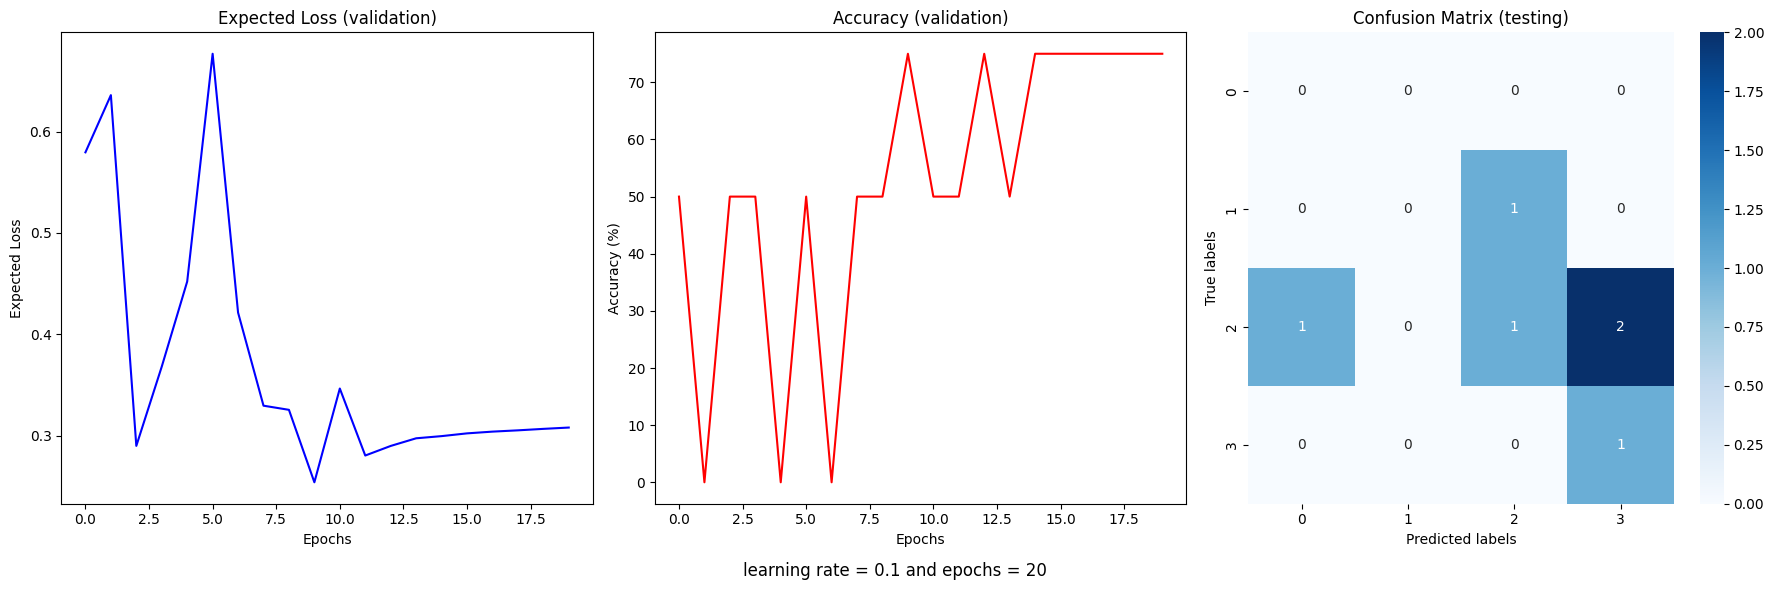

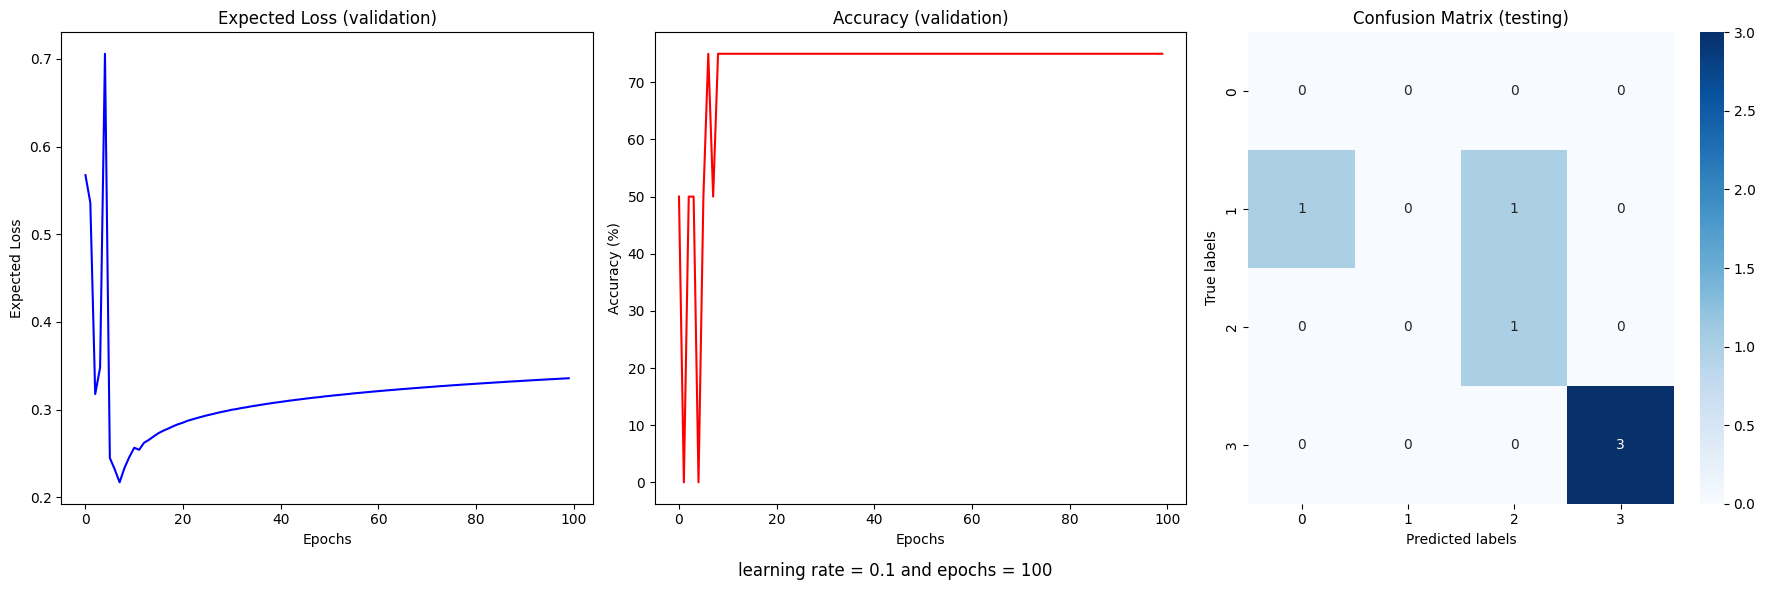

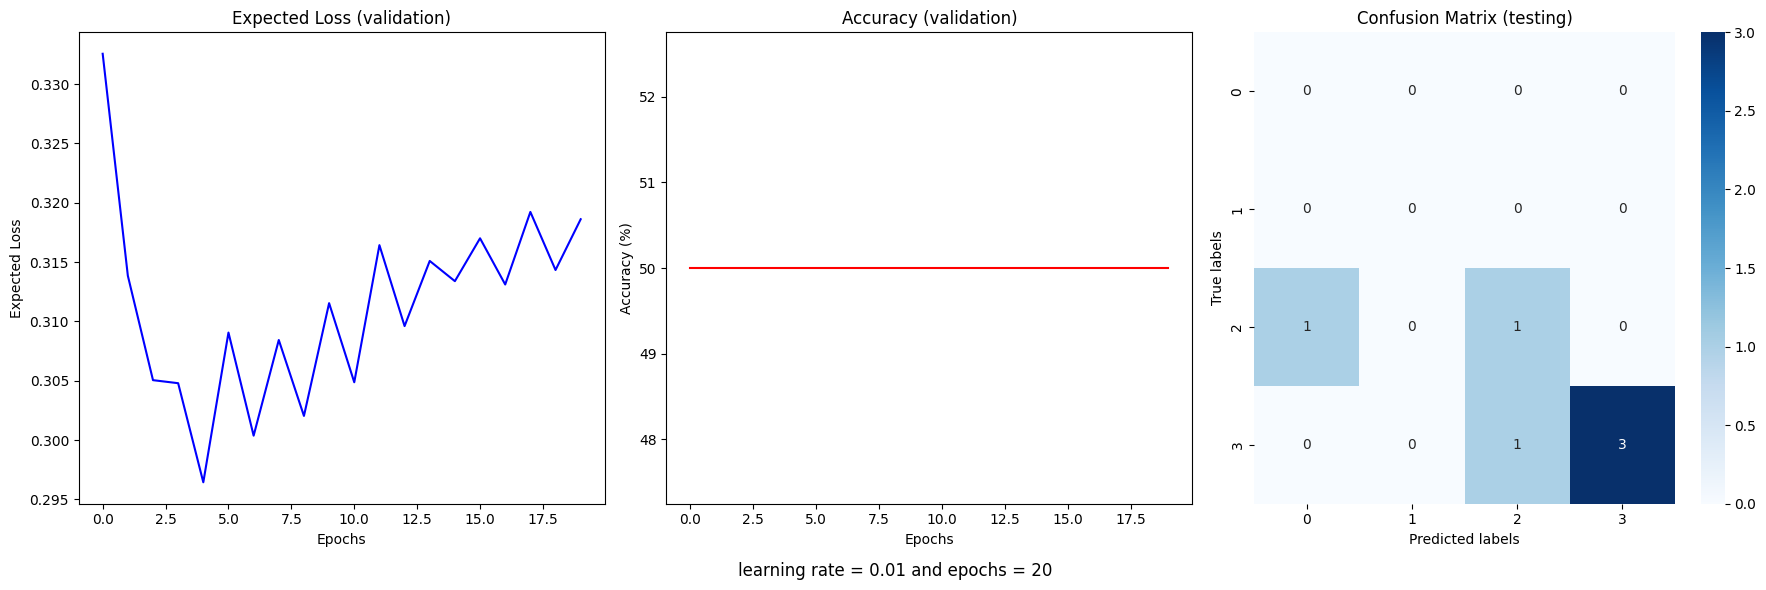

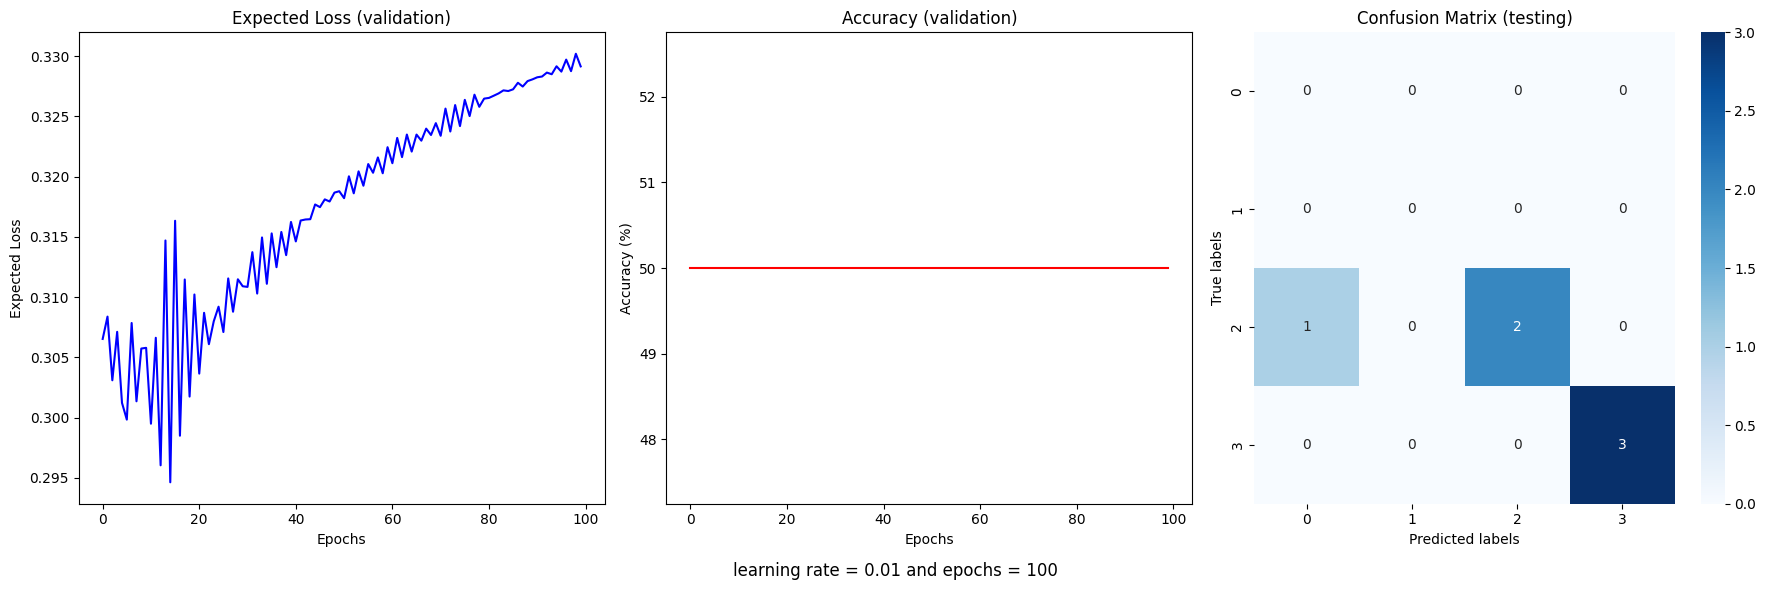

In [90]:
with open("generated/models/results.json", "r") as fp: results = json.load(fp)
# Create figure and subplots
for i in range(len(results)):
    expected_loss = results[i]["training data"]["expected loss"]
    accuracy = results[i]["training data"]["accuracy"]
    confusion_matrix = results[i]["testing data"]["confusion matrix"]
    
    plt.figure(figsize=(18, 6))
    
    # Plot expected loss
    plt.subplot(1, 3, 1)
    plt.plot(expected_loss, color='b')
    plt.title('Expected Loss (validation)')
    plt.xlabel('Epochs')
    plt.ylabel('Expected Loss')
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(accuracy, color='r')
    plt.title('Accuracy (validation)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    
    # Plot confusion matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix (testing)')
    plt.subplots_adjust(bottom=0.2)
    plt.suptitle(f"learning rate = {results[i]['training data']['learning rate']} and epochs = {results[i]['training data']['learning epochs']}", y=0)
    plt.tight_layout()
    plt.show()